In [1]:
!nvidia-smi

Wed Mar 30 11:58:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:3B:00.0 Off |                    0 |
| N/A   19C    P8     9W / 250W |      0MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [2]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import os
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv("data/processed_wikiart_title.csv")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/data/user-data/sa25729/myenv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

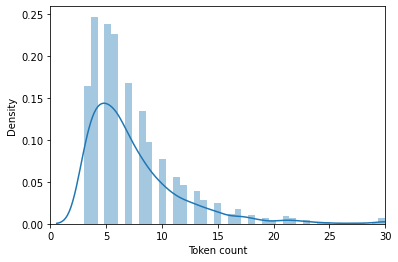

In [4]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased")
token_lens = []

for txt in df.Title:
    tokens = tokenizer.encode(txt, max_length=30)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 30]);
plt.xlabel('Token count')



In [5]:
MAX_LEN = 30
class Wikiart_Dataset(Dataset):

    def __init__(self, title, targets, tokenizer, max_len):
        self.title = title
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.title)
  
    def __getitem__(self, item):
        review = str(self.title[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          
          return_tensors='pt',
        )
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
       
        
        return {
          
          'input_ids': torch.tensor(ids, dtype=torch.long),
           'mask': torch.tensor(mask, dtype=torch.long),
           'targets': torch.tensor(self.targets[item], dtype=torch.float)
        }

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)


In [7]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = Wikiart_Dataset(
    title=df.Title.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data = next(iter(train_data_loader))
data.keys()



/data/user-data/sa25729/myenv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/data/user-data/sa25729/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/user-data/sa25729/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

dict_keys(['input_ids', 'mask', 'targets'])

In [8]:
n_classes=6
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=n_classes).cuda()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [9]:

num_classes = 6
class CE_LS(torch.nn.Module):
    
    def __init__(self, classes= num_classes, smoothing=0, ignore_index=-1):
        super(CE_LS, self).__init__()
        self.smoothing = smoothing
        self.complement = 1.0 - smoothing
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        with torch.no_grad():

            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement + self.smoothing / self.cls
        
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1).mean()
    

loss_fn = CE_LS(classes = num_classes).to(device)


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].squeeze(1).to(device)
        attention_mask = d["mask"].squeeze(1).to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        ).logits

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets.long())

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].squeeze(1).to(device)
            attention_mask = d["mask"].squeeze(1).to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                ).logits
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets.long())

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [12]:
import random
seed_everything()
EPOCHS = 100

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

import warnings
warnings.filterwarnings("ignore")
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
            
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model,test_data_loader,loss_fn, device, len(df_test))

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_wikiart_title_cls_transf.pth')
        best_accuracy = val_acc
        best_epoch = epoch
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f} lr: {:.4f}'.format(
            epoch, val_acc, best_epoch, best_accuracy,optimizer.param_groups[0]['lr']))

Epoch 1/100
----------
Train loss 1.0680078192821985 accuracy 0.6108404384896468
Val loss 0.9647110998630524 accuracy 0.6406820950060901

epoch: 0  acc: 0.6407  best epoch: 0  best acc: 0.6407 lr: 0.0000
Epoch 2/100
----------
Train loss 0.7119111629944403 accuracy 0.7591352009744214
Val loss 0.9909713268280029 accuracy 0.6552984165651644

epoch: 1  acc: 0.6553  best epoch: 1  best acc: 0.6553 lr: 0.0000
Epoch 3/100
----------
Train loss 0.49254523391283833 accuracy 0.843483556638246
Val loss 1.0483484772535472 accuracy 0.6784409257003654

epoch: 2  acc: 0.6784  best epoch: 2  best acc: 0.6784 lr: 0.0000
Epoch 4/100
----------
Train loss 0.33365617432061906 accuracy 0.8934226552984165
Val loss 1.241142282119164 accuracy 0.6577344701583434

epoch: 3  acc: 0.6577  best epoch: 2  best acc: 0.6784 lr: 0.0000
Epoch 5/100
----------
Train loss 0.24269464800080048 accuracy 0.9174786845310596
Val loss 1.3088814524503856 accuracy 0.6723507917174177

epoch: 4  acc: 0.6724  best epoch: 2  best ac

Train loss 0.05103826211712852 accuracy 0.9799025578562728
Val loss 2.3822086361738353 accuracy 0.6833130328867235

epoch: 40  acc: 0.6833  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 42/100
----------
Train loss 0.04874038829658072 accuracy 0.9771619975639464
Val loss 2.365232366781968 accuracy 0.6747868453105969

epoch: 41  acc: 0.6748  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 43/100
----------
Train loss 0.04818117948098095 accuracy 0.9783800243605358
Val loss 2.4240021247130175 accuracy 0.6760048721071863

epoch: 42  acc: 0.6760  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 44/100
----------
Train loss 0.0475235561699238 accuracy 0.9783800243605358
Val loss 2.4721931035702047 accuracy 0.6784409257003654

epoch: 43  acc: 0.6784  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 45/100
----------
Train loss 0.0480162465930193 accuracy 0.9783800243605358
Val loss 2.462191567971156 accuracy 0.6833130328867235

epoch: 44  acc: 0.6833  best epoch: 36  best acc: 0.6906

Train loss 0.04442211374880924 accuracy 0.9817295980511571
Val loss 2.669325136221372 accuracy 0.6723507917174177

epoch: 80  acc: 0.6724  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 82/100
----------
Train loss 0.04458962549730679 accuracy 0.9802070645554202
Val loss 2.6560677656760583 accuracy 0.6760048721071863

epoch: 81  acc: 0.6760  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 83/100
----------
Train loss 0.044209330907055894 accuracy 0.9805115712545676
Val loss 2.6692130978290853 accuracy 0.6686967113276492

epoch: 82  acc: 0.6687  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 84/100
----------
Train loss 0.04411761909757189 accuracy 0.9817295980511571
Val loss 2.6703783181997447 accuracy 0.6735688185140073

epoch: 83  acc: 0.6736  best epoch: 36  best acc: 0.6906 lr: 0.0000
Epoch 85/100
----------
Train loss 0.044450916728449565 accuracy 0.9795980511571254
Val loss 2.670957721196688 accuracy 0.6711327649208282

epoch: 84  acc: 0.6711  best epoch: 36  best acc: 0.

Confidence score

In [11]:
def get_conf_freq (model, dataloader):
    model.eval()
    conf_score = torch.zeros([6]).to(device)
    count = torch.zeros([6]).to(device)
    with torch.no_grad():
        for _, data in enumerate(dataloader, 0):
            inputs = data['input_ids'].squeeze(1).to(device, dtype = torch.long)
            mask = data['mask'].squeeze(1).to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].squeeze(1).to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            logits = model(inputs, mask, token_type_ids)
            softmaxes = F.softmax(logits, dim=1)

            for i in range (len(targets)):
                 
                confidence = softmaxes[i][targets[i]]
                conf_score[targets[i]] += confidence
                count[targets[i]] += 1
            conf_avg = conf_score/count
    return conf_avg

model.load_state_dict(torch.load('best_model_wikiart_title_classi_new_ls_0.20.pth'))
conf_score_train = get_conf_freq(model, train_data_loader)
conf_score_train

/data/user-data/sa25729/myenv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/data/user-data/sa25729/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/user-data/sa25729/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

tensor([0.8167, 0.8399, 0.8422, 0.8287, 0.7249, 0.8400], device='cuda:0')

ECE

In [15]:
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm_notebook
import torch.nn as nn
from sklearn.metrics import f1_score
TRAIN_BATCH_SIZE=32

model.load_state_dict(torch.load('best_model_wikiart_title_cls_transf.pth'))
labels = []
for i in range(len(test_data_loader.dataset)):
    label = test_data_loader.dataset[i]['targets']
    labels.append(label)
labels = np.array(labels)

class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
    
def evaluation(model, testing_loader):
    model.eval()
    total_acc = 0
    total_loss = 0
    count = 0
    pred_all = []
    target_all = []
    logits_list, labels_list = [], [] 
    with torch.no_grad():
        for d in testing_loader:
            input_ids = d["input_ids"].squeeze(1).to(device)
            attention_mask = d["mask"].squeeze(1).to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask).logits
            loss_val = loss_fn(outputs.squeeze(), targets.long())
            predictions = torch.max(outputs, 1)[1].view(targets.size()).data
            pred_all.append(outputs)
            target_all.append(targets)
            
            f1 = f1_score(targets.data.cpu(), predictions.cpu(), average='macro')
            num_corrects = (predictions == targets.data).float().sum()
            acc = 100.0 * num_corrects / TRAIN_BATCH_SIZE
            total_acc += acc.item()
            total_loss += loss_val.item()
            count += 1
        logits_all = torch.cat(pred_all).cuda()
        labels_all = torch.cat(target_all).cuda()
    return total_acc/count,f1, logits_all, labels_all

ece_criterion = _ECELoss().to(device)
accuracy,total_f1, logits_all,labels_all = evaluation(model, test_data_loader)

logits_all = logits_all.view(-1,6)
labels_all = labels_all.view(-1)
temperature_ece = ece_criterion(logits_all, labels_all).item()
temperature_ece

0.2694356143474579

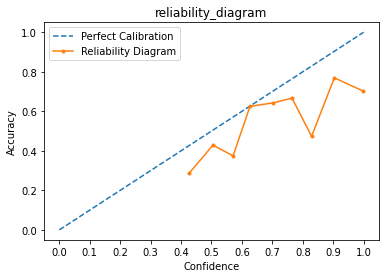

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def ece_eval(preds, targets, n_bins=15, bg_cls = -1):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm


def get_reliability_diagram(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10, fig=2):
    plt.figure(fig)
    plt.plot([0, 1], [0, 1], linestyle='--',label = 'Perfect Calibration')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    plt.title('{}'.format(fig))
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_reliability_diag_{}.png'.format(fig),dpi=300)
    
logits_all =F.softmax(logits_all, dim=1).detach().cpu().numpy()
labels_all =labels_all.detach().cpu().numpy()
ece, acc, conf, Bm = ece_eval(logits_all, labels_all)
get_reliability_diagram(conf, acc, legend='Reliability Diagram', fig='reliability_diagram')

In [14]:
print(conf, type(conf))
print(acc,type(acc))

[0.         0.         0.         0.         0.30918682 0.36304526
 0.4433049  0.50715661 0.56093767 0.63684009 0.71442413 0.77148281
 0.84196868 0.         0.        ] <class 'numpy.ndarray'>
[0.         0.         0.         0.         0.33333333 0.18181818
 0.5        0.75       0.66666667 0.57142857 0.7254902  0.55357143
 0.70917574 0.         0.        ] <class 'numpy.ndarray'>
